## Импорт модулей

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

import numpy as np

## Константы

In [2]:
TRAIN_PATH = "./data/train.csv"
TEST_PATH = "./data/test.csv"
RANDOM_STATE = 777

## Загрузка данных

In [3]:
df_train = pd.read_csv(TRAIN_PATH, index_col="id")

print("Train DataFrame:")
print(df_train.head(), end="\n\n")
df_train.info()

Train DataFrame:
    gravity    ph  osmo  cond  urea  calc  target
id                                               
0     1.013  6.19   443  14.8   124  1.45       0
1     1.025  5.40   703  23.6   394  4.18       0
2     1.009  6.13   371  24.5   159  9.04       0
3     1.021  4.91   442  20.8   398  6.63       1
4     1.021  5.53   874  17.8   385  2.21       1

<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  414 non-null    float64
 1   ph       414 non-null    float64
 2   osmo     414 non-null    int64  
 3   cond     414 non-null    float64
 4   urea     414 non-null    int64  
 5   calc     414 non-null    float64
 6   target   414 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 25.9 KB


In [4]:
df_test = pd.read_csv(TEST_PATH, index_col="id")

print("Test DataFrame Features:")
print(df_test.head(), end="\n\n")
df_test.info()

Test DataFrame Features:
     gravity    ph  osmo  cond  urea   calc
id                                         
414    1.017  5.24   345  11.5   152   1.16
415    1.020  5.68   874  29.0   385   3.46
416    1.024  5.36   698  19.5   354  13.00
417    1.020  5.33   668  25.3   252   3.46
418    1.011  5.87   567  29.0   457   2.36

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 414 to 689
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  276 non-null    float64
 1   ph       276 non-null    float64
 2   osmo     276 non-null    int64  
 3   cond     276 non-null    float64
 4   urea     276 non-null    int64  
 5   calc     276 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 15.1 KB


Можно видеть, что test.csv не содержит целевую переменную, дальнейшую работу будем проводить только с train.csv.

## Исследовательский анализ данных

In [5]:
def calculate_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)

    return stats

In [6]:
train_stats = calculate_stats(df_train)

print("Train DataFrame Statistics:")
train_stats

Train DataFrame Statistics:


,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
gravity,0.0,1.00,1.04,1.02,1.02,0.00,1.01,1.02,1.01,1.02
ph,0.0,4.76,7.94,5.96,5.74,0.41,5.33,6.81,5.53,6.28
osmo,0.0,187.00,1236.00,651.55,679.50,55073.09,343.60,925.20,455.25,840.00
cond,0.0,5.10,38.00,21.44,22.20,56.47,10.90,29.00,15.50,27.60
urea,0.0,10.00,620.00,278.66,277.00,18616.49,95.00,443.00,170.00,385.00
calc,0.0,0.17,14.34,4.11,3.13,10.35,1.05,8.51,1.45,6.63
target,0.0,0.00,1.00,0.44,0.00,0.25,0.00,1.00,0.00,1.00


Данные не содержат пропущенных значений и имеют различный масштаб.

Для целевой переменной 'target' доля 1 соответствует среднему значению и равна 44%.

## Визуализация данных

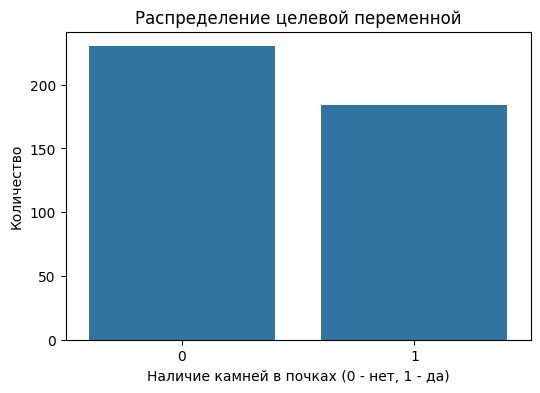

In [7]:
# Гистограмма распределения целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x="target", data=df_train)
plt.title("Распределение целевой переменной")
plt.xlabel("Наличие камней в почках (0 - нет, 1 - да)")
plt.ylabel("Количество")
plt.show()

В наборе данных преобладают примеры с нулевой целевой переменной, что говорит о большем количестве людей без камней в почках.

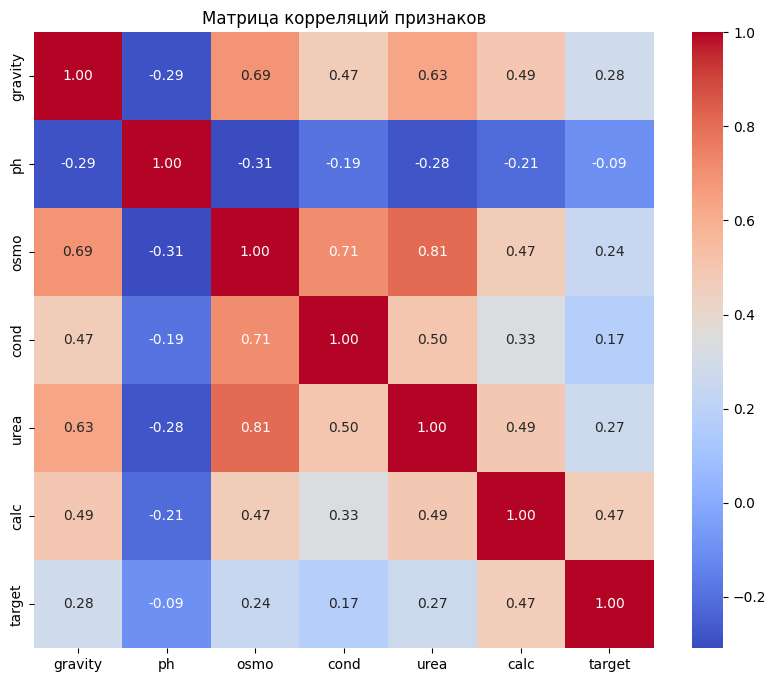

In [8]:
# Матрица корреляций
plt.figure(figsize=(10, 8))
correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций признаков")
plt.show()

Можно видеть, что признак osmo имеет высокую корреляцию с urea, cond и gravity. Удалим его из датасета.

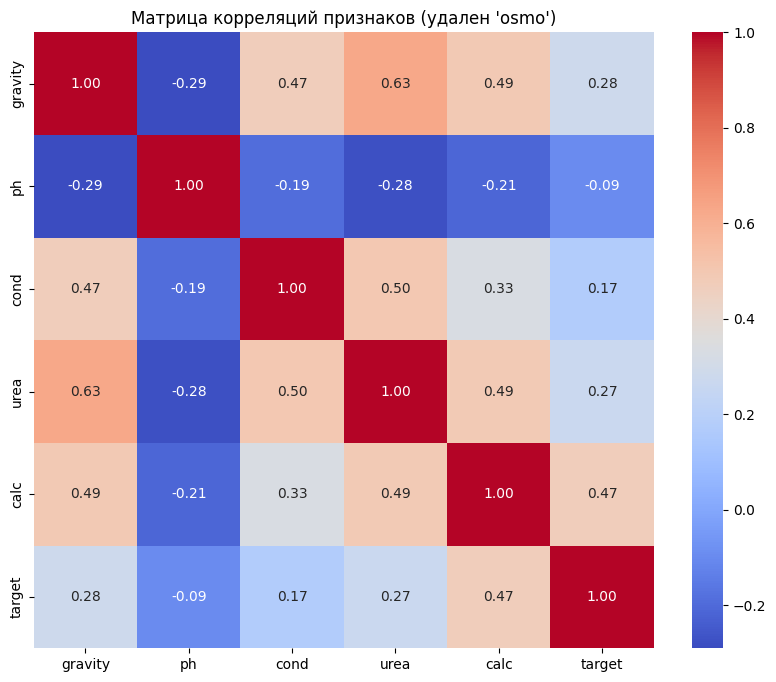

In [9]:
df_train = df_train.drop(columns=["osmo"])

# Матрица корреляций после удаления признака
plt.figure(figsize=(10, 8))
correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций признаков (удален 'osmo')")
plt.show()

Картина скоррелированности признаков несколько улучшилась.

## Обучение модели kNN и подбор гиперпараметра k

Разделение данных.

In [10]:
X = df_train.drop(columns=["target"])
y = df_train["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

 Масштабирование признаков.

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Подбор гиперпараметра k.

In [12]:
k_values = range(1, 6)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring="f1_macro")
    cv_scores.append(scores.mean())

optimal_k = k_values[np.argmax(cv_scores)]
print(
    f"Оптимальное значение k: {optimal_k}\nМаксимум cv_scores: {round(max(cv_scores), 4)}"
)

Оптимальное значение k: 5
Максимум cv_scores: 0.7162


Выбираем значение k, при котором достигается наибольшая величина метрики.

## Оценка качества модели

In [13]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

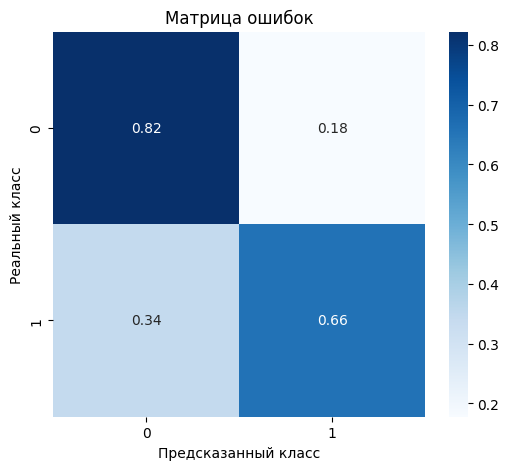

In [14]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues")
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Матрица ошибок")
plt.show()

In [15]:
print("Метрики классификации:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Метрики классификации:
Accuracy: 0.7470
Precision: 0.7576
Recall: 0.6579
F1-score: 0.7042
ROC-AUC: 0.7705


Модель справляется с задачей, но имеет низкое значение recall (высокая доля ложноотрицательных ответов). Это может быть связано с небольшим набором данных, а также с дисбалансом классов.